In [5]:
import cv2
from matplotlib import pyplot as plt
import PIL.Image as Image
import numpy as np

In [6]:
def crop_for_filling_pre(image: np.array, mask: np.array, crop_size: int = 512):
    # Calculate the aspect ratio of the image
    height, width = image.shape[:2]
    aspect_ratio = float(width) / float(height)

    # If the shorter side is less than 512, resize the image proportionally
    if min(height, width) < crop_size:
        if height < width:
            new_height = crop_size
            new_width = int(new_height * aspect_ratio)
        else:
            new_width = crop_size
            new_height = int(new_width / aspect_ratio)

        image = cv2.resize(image, (new_width, new_height))
        mask = cv2.resize(mask, (new_width, new_height))

    # Find the bounding box of the mask
    x, y, w, h = cv2.boundingRect(mask)

    # Update the height and width of the resized image
    height, width = image.shape[:2]

    # # If the 512x512 square cannot cover the entire mask, resize the image accordingly
    if w > crop_size or h > crop_size:
        # padding to square at first
        if height < width:
            padding = width - height
            image = np.pad(image, ((padding // 2, padding - padding // 2), (0, 0), (0, 0)), 'constant')
            mask = np.pad(mask, ((padding // 2, padding - padding // 2), (0, 0)), 'constant')
        else:
            padding = height - width
            image = np.pad(image, ((0, 0), (padding // 2, padding - padding // 2), (0, 0)), 'constant')
            mask = np.pad(mask, ((0, 0), (padding // 2, padding - padding // 2)), 'constant')

        resize_factor = crop_size / max(w, h)
        image = cv2.resize(image, (0, 0), fx=resize_factor, fy=resize_factor)
        mask = cv2.resize(mask, (0, 0), fx=resize_factor, fy=resize_factor)
        x, y, w, h = cv2.boundingRect(mask)

    # Calculate the crop coordinates
    crop_x = min(max(x + w // 2 - crop_size // 2, 0), width - crop_size)
    crop_y = min(max(y + h // 2 - crop_size // 2, 0), height - crop_size)

    # Crop the image
    cropped_image = image[crop_y:crop_y + crop_size, crop_x:crop_x + crop_size]
    cropped_mask = mask[crop_y:crop_y + crop_size, crop_x:crop_x + crop_size]

    return cropped_image, cropped_mask
    
    
def crop_for_filling_post(
        image: np.array,
        mask: np.array,
        filled_image: np.array, 
        crop_size: int = 512,
        ):
    image_copy = image.copy()
    mask_copy = mask.copy()
    # Calculate the aspect ratio of the image
    height, width = image.shape[:2]
    height_ori, width_ori = height, width
    aspect_ratio = float(width) / float(height)

    # If the shorter side is less than 512, resize the image proportionally
    if min(height, width) < crop_size:
        if height < width:
            new_height = crop_size
            new_width = int(new_height * aspect_ratio)
        else:
            new_width = crop_size
            new_height = int(new_width / aspect_ratio)

        image = cv2.resize(image, (new_width, new_height))
        mask = cv2.resize(mask, (new_width, new_height))

    # Find the bounding box of the mask
    x, y, w, h = cv2.boundingRect(mask)

    # Update the height and width of the resized image
    height, width = image.shape[:2]

    # # If the 512x512 square cannot cover the entire mask, resize the image accordingly
    if w > crop_size or h > crop_size:
        flag_padding = True
        # padding to square at first
        if height < width:
            padding = width - height
            image = np.pad(image, ((padding // 2, padding - padding // 2), (0, 0), (0, 0)), 'constant')
            mask = np.pad(mask, ((padding // 2, padding - padding // 2), (0, 0)), 'constant')
            padding_side = 'h'
        else:
            padding = height - width
            image = np.pad(image, ((0, 0), (padding // 2, padding - padding // 2), (0, 0)), 'constant')
            mask = np.pad(mask, ((0, 0), (padding // 2, padding - padding // 2)), 'constant')
            padding_side = 'w'

        resize_factor = crop_size / max(w, h)
        image = cv2.resize(image, (0, 0), fx=resize_factor, fy=resize_factor)
        mask = cv2.resize(mask, (0, 0), fx=resize_factor, fy=resize_factor)
        x, y, w, h = cv2.boundingRect(mask)
    else:
        flag_padding = False

    # Calculate the crop coordinates
    crop_x = min(max(x + w // 2 - crop_size // 2, 0), width - crop_size)
    crop_y = min(max(y + h // 2 - crop_size // 2, 0), height - crop_size)

    # Fill the image
    image[crop_y:crop_y + crop_size, crop_x:crop_x + crop_size] = filled_image
    if flag_padding:
        image = cv2.resize(image, (0, 0), fx=1/resize_factor, fy=1/resize_factor)
        if padding_side == 'h':
            image = image[padding // 2:padding // 2 + height_ori, :]
        else:
            image = image[:, padding // 2:padding // 2 + width_ori]

    image = cv2.resize(image, (width_ori, height_ori))

    image_copy[mask_copy==255] = image[mask_copy==255]
    return image_copy

In [7]:
def plot_image(image, title):
    """Utility function to plot an image with matplotlib."""
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')


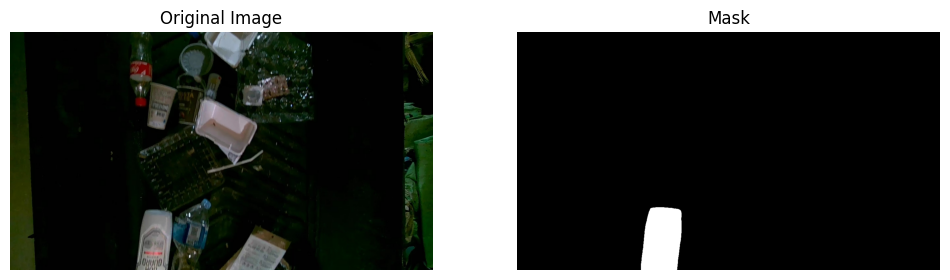

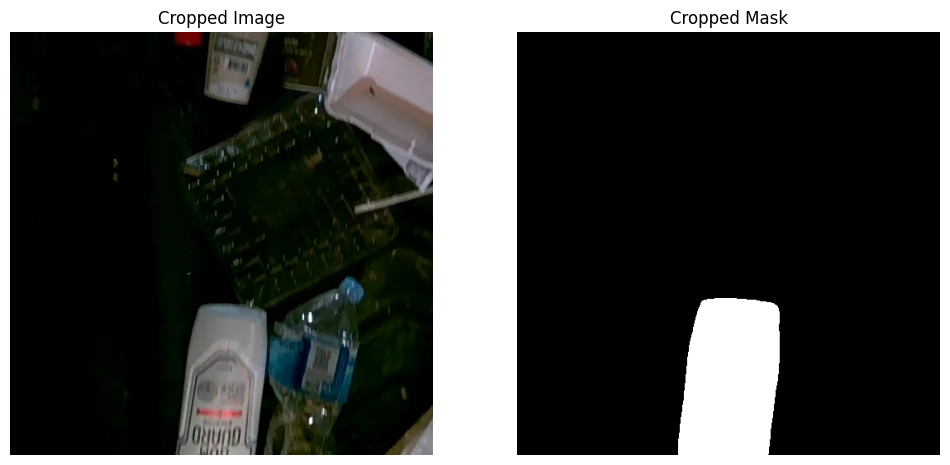

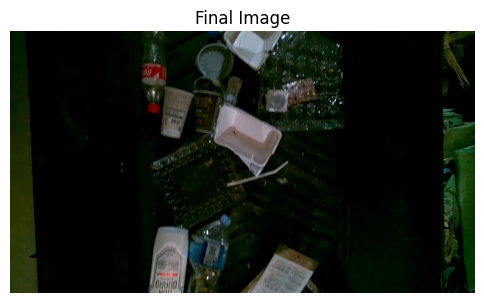

break_point


In [9]:
image = cv2.imread('../wim_data/train/images/2023-04-21_48.mp4#t=0.jpg')
mask = cv2.imread('./results/2023-04-21_48.mp4#t=0/mask_2.png', cv2.IMREAD_GRAYSCALE)

# Show original image and mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_image(image, 'Original Image')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()

cropped_image, cropped_mask = crop_for_filling_pre(image, mask)
# ^ ------------------------------------------------------------------------------------
# ^ Please conduct inpainting or filling here on the cropped image with the cropped mask
# ^ ------------------------------------------------------------------------------------

# Show cropped image and mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_image(cropped_image, 'Cropped Image')
plt.subplot(1, 2, 2)
plt.imshow(cropped_mask, cmap='gray')
plt.title('Cropped Mask')
plt.axis('off')
plt.show()

image = crop_for_filling_post(image, mask, cropped_image)
#cv2.imwrite('filled_image.jpg', image)
plt.figure(figsize=(6, 6))
plot_image(image, 'Final Image')
plt.show()

print('break_point')

In [13]:
from diffusers import StableDiffusionInpaintPipeline
from utils.mask_processing import crop_for_filling_pre, crop_for_filling_post
from utils.crop_for_replacing import recover_size, resize_and_pad
from utils import load_img_to_array, save_array_to_img
import torch

In [11]:
def fill_img_with_sd(
        img: np.ndarray,
        mask: np.ndarray,
        text_prompt: str,
        device="cuda"
):
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float32,
    ).to(device)
    img_crop, mask_crop = crop_for_filling_pre(img, mask)
    img_crop_filled = pipe(
        prompt=text_prompt,
        image=Image.fromarray(cropped_image),
        mask_image=Image.fromarray(cropped_mask)
    ).images[0]
    img_filled = crop_for_filling_post(img, mask, np.array(img_crop_filled))
    return img_filled

In [14]:
device="cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float32,
    ).to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


In [16]:
text_prompt = "coke can"

In [18]:
img_crop_filled = pipe(
        prompt=text_prompt,
        image=Image.fromarray(cropped_image),
        mask_image=Image.fromarray(cropped_mask)
    ).images[0]

100%|██████████| 50/50 [00:05<00:00,  8.80it/s]


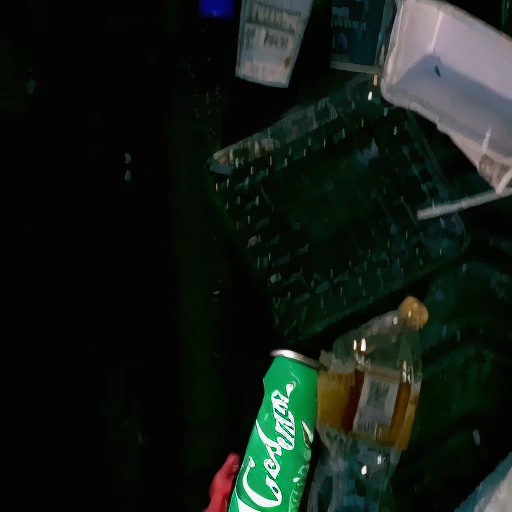

In [19]:
img_crop_filled

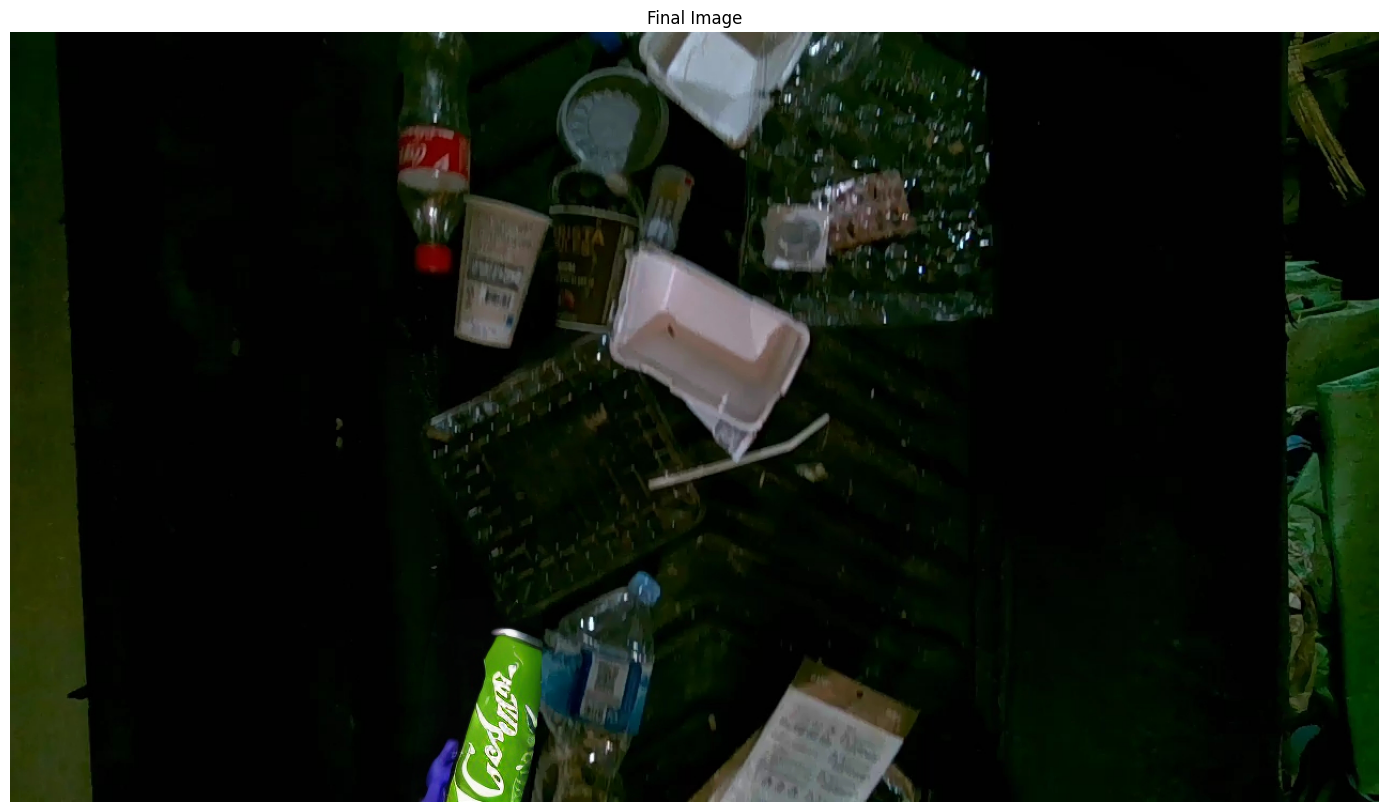

In [24]:
image = crop_for_filling_post(image, mask, np.array(img_crop_filled))
#cv2.imwrite('filled_image.jpg', image)
plt.figure(figsize=(20, 10))
plot_image(image, 'Final Image')
plt.show()